# Sistemas Dinâmicos e Controlo - Projeto

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import StateSpace, lsim, step, lti
from pprint import pprint

In [2]:
m = 1.5 * 10 ** -1 # motorcycle mass
g = 9.81 # gravity
h = 8.0 * 10 ** -1 # height of center of mass
I = 1.5 * 10 ** -2 # moment of inertia

## Ex. 1

$$ I \ddot{\theta} = mgh \cdot sin(\theta) + \tau $$

At small angles $ sin(\theta) \approx \theta $.

$$ I \ddot{\theta} = mgh \cdot \theta + \tau $$

$$ \ddot{\theta} = \frac{mgh \cdot \theta}{I} + \frac{\tau}{I} $$

$$ x = \begin{bmatrix} 
 \theta \\
 \dot{\theta} \\
\end{bmatrix} \Leftrightarrow \dot{x} = \begin{bmatrix} 
 \dot{\theta} \\
 \ddot{\theta} \\
\end{bmatrix} \Leftrightarrow \dot{x} = \begin{bmatrix} 
 \dot{\theta} \\
 \frac{mgh}{I}\cdot \theta + \frac{\tau}{I} \\
\end{bmatrix} \Leftrightarrow \dot{x} = \begin{bmatrix} 
 \dot{\theta} \\
 \frac{mgh}{I}\cdot \theta \\
\end{bmatrix} + \begin{bmatrix}
0 \\
\frac{\tau}{I}
\end{bmatrix}  \Leftrightarrow \dot{x} = \begin{bmatrix} 
 0 & 1 \\
 \frac{mgh}{I}  & 0\\
\end{bmatrix} \begin{bmatrix}
 \theta \\
 \dot{\theta}
\end{bmatrix} + \begin{bmatrix}
0 \\
\frac{\tau}{I}
\end{bmatrix}  $$

Since $ u = \tau $:

$$
\dot{x} = \begin{bmatrix} 
 0 & 1 \\
 \frac{mgh}{I}  & 0\\
\end{bmatrix} \begin{bmatrix}
 \theta \\
 \dot{\theta}
\end{bmatrix} + \begin{bmatrix}
0 \\
\frac{1}{I}
\end{bmatrix} u $$

Since $\theta$ and $\dot{\theta}$ are also the output, $y$:

$$ y = C \cdot x \Leftrightarrow y = C \cdot \begin{bmatrix}
\theta \\ \dot \theta
\end{bmatrix} \Leftrightarrow y = \begin{bmatrix}
1 & 0 \\
0 & 1 \\
\end{bmatrix} \cdot \begin{bmatrix}
\theta \\ \dot \theta
\end{bmatrix} \Leftrightarrow C = \begin{bmatrix}
1 & 0 \\
0 & 1 \\
\end{bmatrix} $$
 


In [3]:
A = np.array([[0, 1],[m * g * h / I, 0]])
B = np.array([[0],[1 / I]])
C = np.array([[1, 0],[0, 1]])
D = np.array([[0],[0]])

print("Matriz A: ")
pprint(A)
print("Matrix B: ")
pprint(B)
print("Matrix C: ")
pprint(C)

Matriz A: 
array([[ 0.  ,  1.  ],
       [78.48,  0.  ]])
Matrix B: 
array([[ 0.        ],
       [66.66666667]])
Matrix C: 
array([[1, 0],
       [0, 1]])


## Ex.2

Controlability Matrix:

$$ Q = \begin{bmatrix} B & AB & A^{2}B & ... & A^{n-1}B \end{bmatrix} $$

Since $n=2$ and the controlability matrix is squared, if $ |Q| \neq 0 $, the system is controllable, if $ |Q| = 0 $, the system is not controllable.

$$ Q = \begin{bmatrix} B & AB  \end{bmatrix} $$

Other way to check, is to see if $rank(Q)=n$, then it's controllable.

In [4]:
Q = np.hstack([B, A @ B])
n=2

In [5]:
print("Controlability Matrix: ")
pprint(Q)
print("Determinant: ", np.linalg.det(Q))
print("Rank: ", np.linalg.matrix_rank(Q))

if np.linalg.det(Q) != 0:
    print("According to the determinant, the system is controllable")
else:
    print("According to the determinant, the system is not controllable")

if np.linalg.matrix_rank(Q) == n:
    print("According to the rank, the system is controllable.")
else:
    print("According to the rank, the system is not controllable.")

Controlability Matrix: 
array([[ 0.        , 66.66666667],
       [66.66666667,  0.        ]])
Determinant:  -4444.444444444446
Rank:  2
According to the determinant, the system is controllable
According to the rank, the system is controllable.


Observability Matrix:


$$ O = \begin{bmatrix} C \\ CA \\ CA^{2} \\ ... \\ CA^{n-1} \end{bmatrix} $$

If $rank(O)=n$, it's observable.

In [6]:
O = np.vstack([C, C @ A])  # Stack rows for observability

print("Observability Matrix:")
pprint(O)
print("Rank: ", np.linalg.matrix_rank(O))

if np.linalg.matrix_rank(O) == n: #n continua a ser 2 porque é o número de estados
    print("According to the rank, the system is observable.")
else:
    print("According to the rank, the system is not observable.")

Observability Matrix:
array([[ 1.  ,  0.  ],
       [ 0.  ,  1.  ],
       [ 0.  ,  1.  ],
       [78.48,  0.  ]])
Rank:  2
According to the rank, the system is observable.


Stability:

A system is stable if the real part of the eigenvalues is negative.

In [7]:
eigval, eigvect = np.linalg.eig(A)

print("Eigenvalues: ",eigval)

if eigval.real.any()<0: 
    print("The system is stable.")
else:
    print("The system is not stable.")

Eigenvalues:  [ 8.85889384 -8.85889384]
The system is not stable.


To stabilize this system, we can introduce a controller $K=[k_1 k_2]$ such that it stabilizes with poles at the system eigenvalues:

$$ det(sI-A+BK) = (s-\lambda_1)(s-\lambda_2) = s^2 - \lambda^2 $$

Where: 

$$ det(sI-A+BK) =  
det \begin{bmatrix} 
 s & 1 \\
 -\frac{mgh}{I}+\frac{k_1}{I}  & s+\frac{k_2}{I}\\
\end{bmatrix}  = s^2 + \frac{k_2}{I}s -1(\frac{k_1}{I}-\frac{mgh}{I})
$$

So:

$$ k_2=0 $$ 
and 
$$ k_1=I\lambda^2 + mgh $$

This way, the system can be stabilized.

In [8]:
K = np.hstack([I*eigval[0]+m*g*h,0])

print("Controller: ",K)

Controller:  [1.31008341 0.        ]


## Ex.3

In [9]:
# Sistema no formato lti (linear time-invariant)
sys = lti(A, B, C, D)

time = np.linspace(0, 5, 50)  # tempo de simulação

#### a) Step input, u = 10**-2, and null initial conditions, x0 = [0, 0]

In [10]:
# Resposta temporal - Condição inicial nula e entrada tipo degrau
u_step = np.ones_like(time) * 1e-2  # degrau de magnitude 10^-2 (eu não sei se aqui ele quer só a constante ou vários degraus)
x0_zero = [0, 0]  # condição inicial nula

# Simulação para entrada tipo degrau
_, y_step, _ = lsim(sys, U=u_step, T=time, X0=x0_zero)

#### b) Null input, u = 0, and non-null initial conditions, x0 = [x01, x02]

In [11]:
# Resposta temporal - Condição inicial não nula e entrada nula
x0_nonzero = [100,100]  # condição inicial não nula
u_zero = np.zeros_like(time)  # entrada nula

# Simulação para condição inicial não nula
_, y_initial, _ = lsim(sys, U=u_zero, T=time, X0=x0_nonzero)

Gráficos

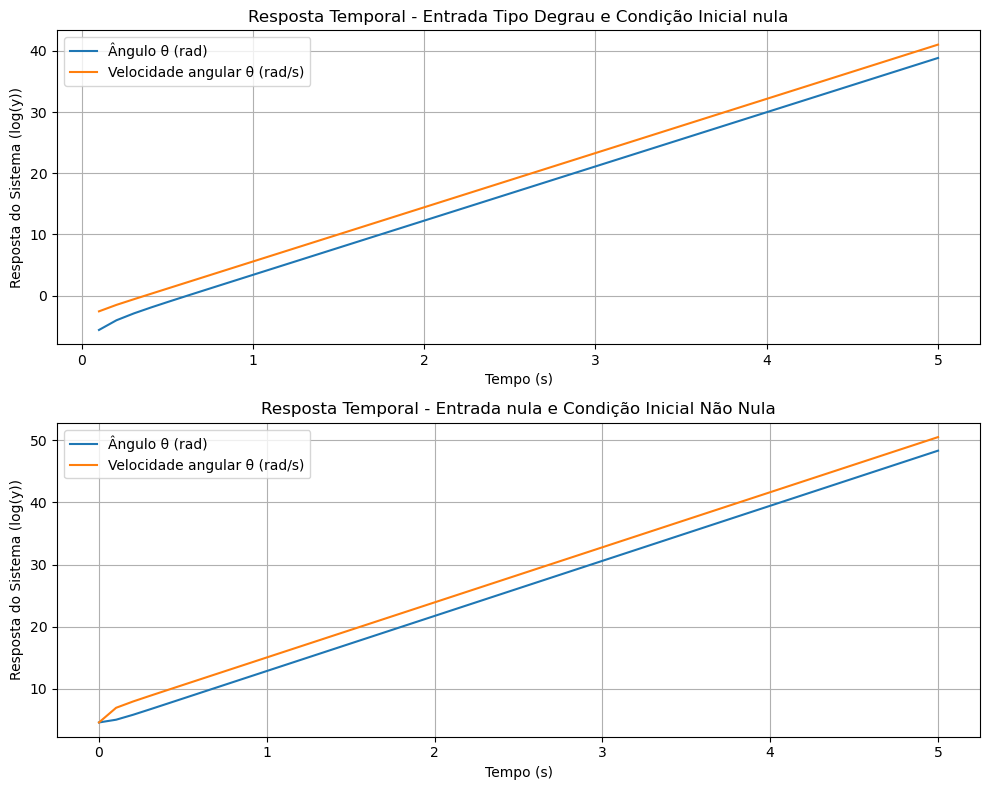

In [12]:
# Gráficos para análise
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# Gráfico para entrada degrau (aqui tirei o primeiro ponto do gráfico porque dá erro pôr 0 no log)
axs[0].plot(time[1:], np.log(y_step[1:, 0]), label="Ângulo θ (rad)")
axs[0].plot(time[1:], np.log(y_step[1:, 1]), label="Velocidade angular θ̇ (rad/s)")
axs[0].set_title("Resposta Temporal - Entrada Tipo Degrau e Condição Inicial nula")
axs[0].set_xlabel("Tempo (s)")
axs[0].set_ylabel("Resposta do Sistema (log(y))")
axs[0].legend()
axs[0].grid()

# Gráfico para condição inicial não nula
axs[1].plot(time, np.log(y_initial[:, 0]), label="Ângulo θ (rad)")
axs[1].plot(time, np.log(y_initial[:, 1]), label="Velocidade angular θ̇ (rad/s)")
axs[1].set_title("Resposta Temporal - Entrada nula e Condição Inicial Não Nula")
axs[1].set_xlabel("Tempo (s)")
axs[1].set_ylabel("Resposta do Sistema (log(y))")
axs[1].legend()
axs[1].grid()

plt.tight_layout()
plt.show()

## Design of Controllers in State Space

### Ex.4